<a href="https://colab.research.google.com/github/erichsdb/Neurocomputing/blob/main/notebooks/7-SoftmaxClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Softmax classification

In this exercise, you will implement a softmax classifier for multi-class classification.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Loading the data

Let's now import the `digits` dataset provided by `scikit-learn`:

<https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html>

It contains 1797 small (8x8) black and white images of digits between 0 and 9.

The two following cells load the data and visualize 16 images chosen randomly.

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()

N, w, h = digits.images.shape
d = w * h # number of pixels
c = len(digits.target_names) # number of classes

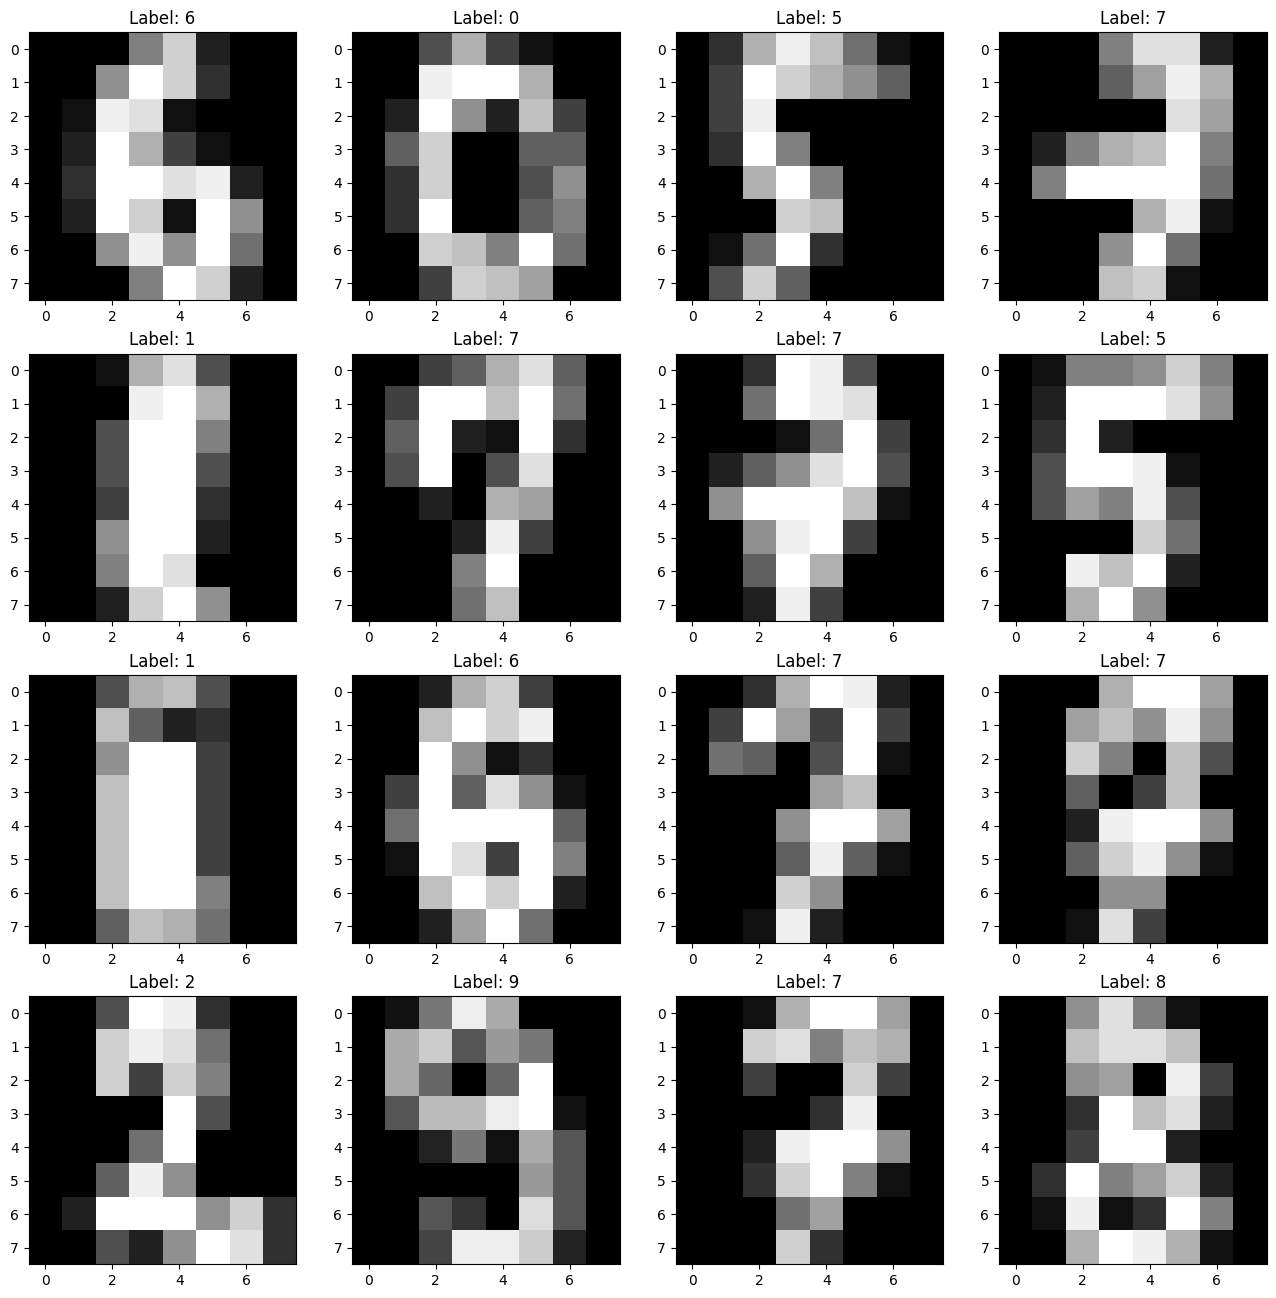

In [3]:
rng = np.random.default_rng()
indices = rng.choice(N, 16)
plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(digits.images[indices[i], :], cmap="gray")
    plt.title("Label: "+ str(digits.target[indices[i]]))
plt.show()

Digits are indeed to be recognized, the hope being that they are linearly separable and we can apply a softmax classifier directly on the pixels.

The only problem is that each image is a 8x8 matrix, while we want vectors for our model. Fortunately, that is very easy with `reshape`:

In [4]:
X = digits.images.reshape((N, d))
print(X.shape)

(1797, 64)


Let's know have a look at the targets, i.e. the ground truth / labels of each digit:

In [5]:
labels = digits.target
print(labels)
print(labels.shape)

[0 1 2 ... 8 9 8]
(1797,)


Each label is an integer between 0 and 9, while our softmax classifier expects a **one-hot-encoded** vector of 10 classes, with only one non-zero element, for example for digit 3:

$$[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]$$

To do the conversion, we can once again use a built-in method of `scikit-learn`:

In [6]:
from sklearn.preprocessing import OneHotEncoder

t = OneHotEncoder().fit_transform(labels.reshape(-1, 1)).toarray()

print(t)
print(t.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]
(1797, 10)


**Q:** Split the data into a training set `X_train, t_train` and a test set `X_test, t_test` using `scikit-learn` (e.g. with a ratio 70/30).

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3)

## Softmax linear classifier

Let's remember the structure of the softmax linear classifier: the input vector $\mathbf{x}$ is transformed into a **logit score** vector $\mathbf{z}$ using a weight matrix $W$ and a bias vector $\mathbf{b}$:

$$
    \mathbf{z} = W \times \mathbf{x} + \mathbf{b}
$$

This logit score has one element per class, so the weight matrix must have a size $(c, d)$, where $c$ is the number of classes (10) and $d$ is the number of dimensions of the input space (64). The bias vector has 10 elements (one per class).

The logit score is turned into probabilities using the **softmax** operator:

$$
    y_j = P(\text{class = j}) = \frac{\exp(z_j)}{\sum_k \exp(z_k)}
$$

The following Python function allows to turn any vector $\mathbf{z}$ (numpy array) into softmax probabilities:

In [8]:
def softmax(z):
    e = np.exp(z - z.max())
    return e/np.sum(e)

**Q:** Experiment with the `softmax()` to understand its function. Pass it different numpy arrays (e.g. [-1, 0, 2]) and print or plot the corresponding probabilities.  

In [10]:
test_array = np.array([-1, 0, 2])
print(softmax(test_array))

[0.04201007 0.1141952  0.84379473]




```
# Als Code formatiert
```

The loss function to use is the **cross-entropy** or **negative log-likelihood**, defined for a single example as:

$$
    \mathcal{l}(W, \mathbf{b}) =   - \mathbf{t} \cdot \log \mathbf{y} = - \log y_j
$$

where $\mathbf{t}$ is a one-hot encoding of the class of the example and $j$ is the index of the corresponding class.

After doing the derivations, we obtain the following learning rules for $W$ and $\mathbf{b}$ to minimize the loss function:

$$
    \Delta W = \eta \, (\mathbf{t} - \mathbf{y}) \, \mathbf{x}^T
$$

$$
    \Delta \mathbf{b} = \eta \, (\mathbf{t} - \mathbf{y})
$$

Note that because $W$ is a $(c, d)$ matrix, $\Delta W$ too. $(\mathbf{t} - \mathbf{y}) \, \mathbf{x}^T$ is therefore the **outer product** between the error vector $\mathbf{t} - \mathbf{y}$ ($c$ elements) and the input vector $\mathbf{x}$ ($d$ elements).

## Implementation

You will now modify your implementation of the online Perceptron algorithm from last week.

Some things to keep in mind:

* `W` must now be defined as a $(c, d)$ matrix (numpy array) and `b` as a vector with $c$ elements. Both can be initialized to 0.

* When computing the logit score $\mathbf{z} = W \times \mathbf{x} + \mathbf{b}$, remember that `W` is now a matrix, so its position will matter in the dot product `np.dot`.

* Use the `softmax()` function defined above on the whole vector instead of `np.sign()` or `logistic` to get the prediction $\mathbf{y}$.

* For $\Delta W$, you will need the **outer** product between the vectors $\mathbf{t} - \mathbf{y}_\text{train}$ and $\mathbf{x}_\text{train}$. Check the doc for `np.outer()`.

* The one-hot encoding of the class of the example $i$ is now a vector with 10 elements `t_train[i, :]`. You can get the index of the corresponding class by looking at the position of its maximum with `t_train[i, :].argmax()`.

* Similarly, the predicted class by the model can be identified by the class with the maximum probability: `y.argmax()`.

* Do not forget to record and plot the evolution of the training error and loss. Compute the test error and loss at the end of learning.

* Pick the right learning rate and number of epochs.

**Q:** Let's go.

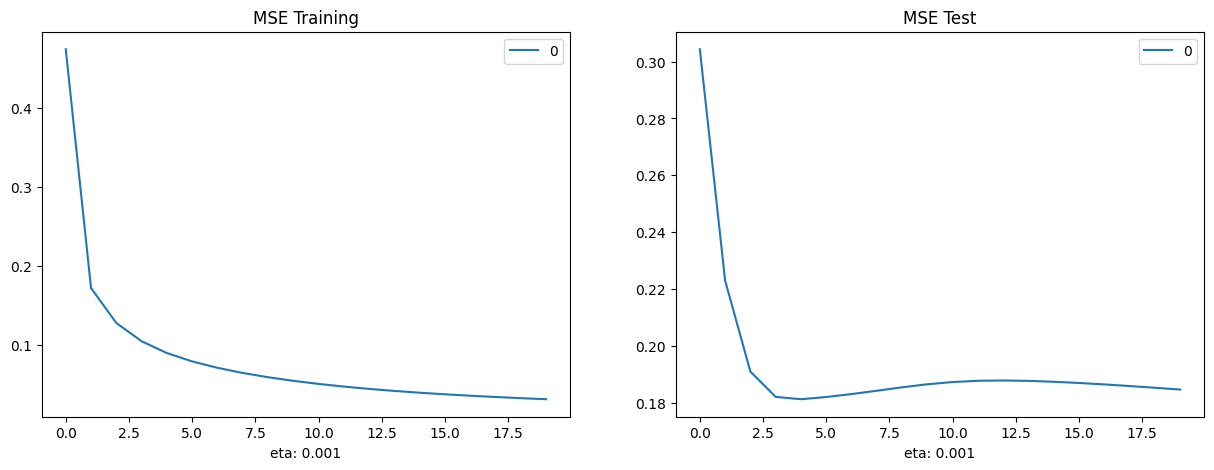

In [113]:
eta_list=[1e-3]
N = len(X_train);

for eta in eta_list:
  N_epochs = 20
  mse_list = []
  mse_test = []

  w = np.zeros((c, d))
  b = np.zeros(c)

  for i in range(N_epochs):
    classification_error = 0
    loss = 0
    for j in range(len(X_train)):
        # Prediction
        y_i = softmax(np.dot(w, X_train[j, :]) + b)
        # Update the weight
        w += eta * np.outer((t_train[j] - y_i), X_train[j, :])
        # Update the bias
        b += eta * (t_train[j] - y_i)
        # Loss mse
        #print(t_train[i, :].argmax())
        # print(y_i.argmax())
        # loss += -t_train[j] * np.log(y_i)
        loss -= np.log(y_i[t_train[j,:].argmax()])

    mse_list.append(loss / N)

    loss_test = 0
    for j in range(len(X_test)):
        # Prediction
        y_i = softmax(np.dot(w, X_test[j, :]) + b)
        # Loss mse
        loss_test -= np.log(y_i[t_test[j,:].argmax()])
    mse_test.append(loss_test / len(X_test))

# show both plots horizontically alinged
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(mse_list)
plt.title('MSE Training')
plt.xlabel("eta: " + str(eta))
# legend is the epoch
plt.legend(range(N_epochs))

plt.subplot(1, 2, 2)
plt.plot(mse_test)
plt.title('MSE Test')
plt.xlabel("eta: " + str(eta))
# legend is the epoch
plt.legend(range(N_epochs))
plt.show()

**Q:** What is the final training error and loss of the model? After how many epochs do you get a perfect classification? Why do they evolve like this?

*Hint:* you may need to avoid plotting the error/loss during the first 20 epochs or so to observe the effect.

**Q:** Compare the evolution of the training and test errors during training. What happens?

**Q:** The following cell samples 12 misclassified images from the test and shows the predicted class together with the ground truth. What do you think?

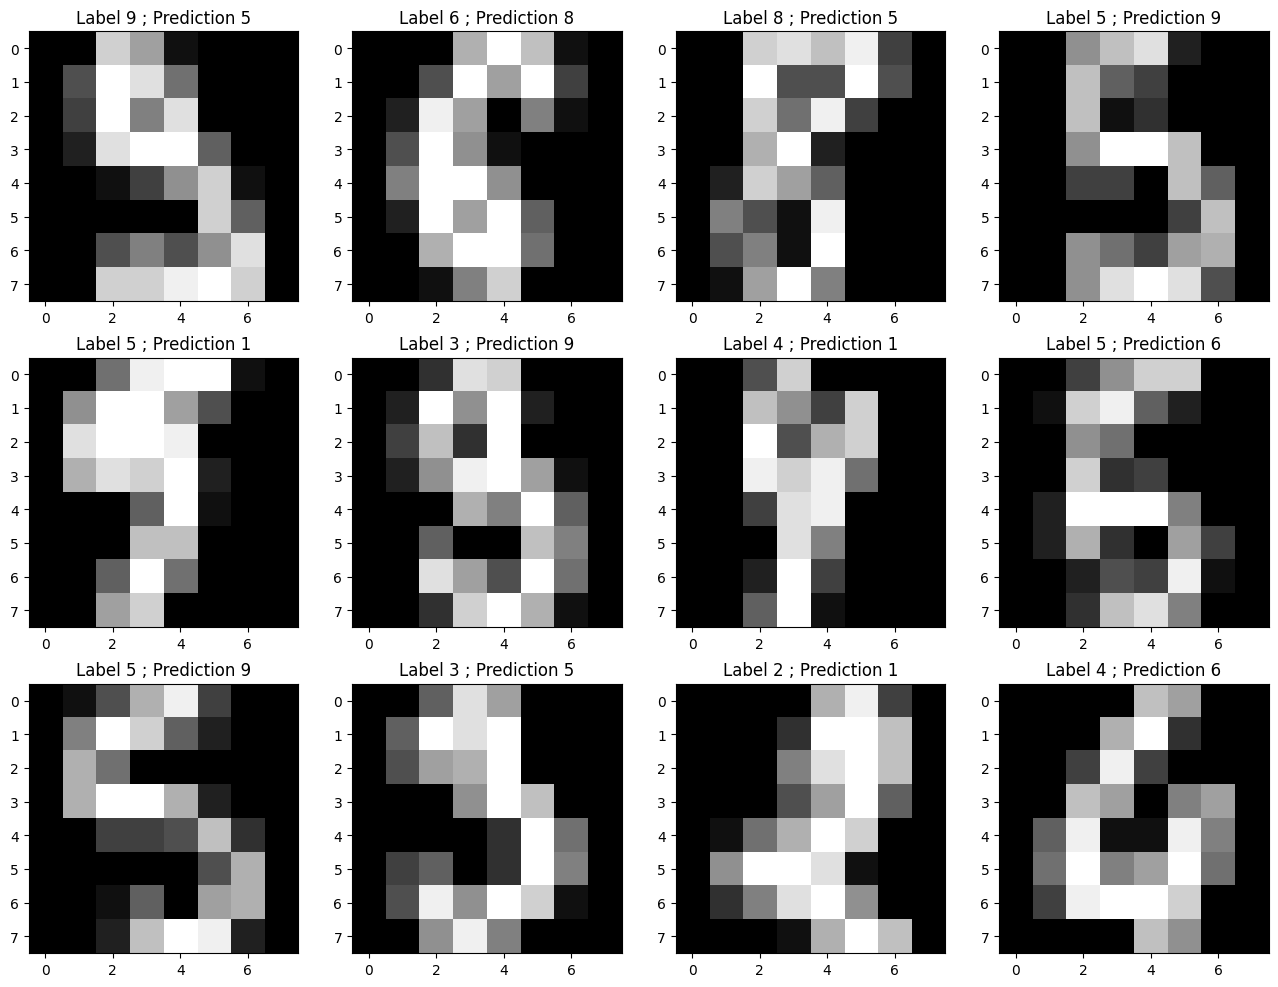

In [102]:
misclassified = []

N_test = len(X_test)

for i in range(N_test):
    pred = softmax(np.dot(w, X_test[i, :]) + b).argmax()
    if pred != t_test[i, :].argmax():
        misclassified.append([X_test[i, :].reshape((8, 8)), t_test[i, :].argmax(), pred])
        if len(misclassified) > 12: break


plt.figure(figsize=(16, 12))
for i in range(12):
    if i < len(misclassified):
        X, t, pred = misclassified[i]
        plt.subplot(3, 4, i+1)
        plt.imshow(X, cmap="gray")
        plt.title("Label " + str(t) + " ; Prediction " + str(pred))

plt.show()